## Goal
In this notebook we will focus on segmenting and tracking the nuclei by themselves.

## Pipeline
1. Segment Hoechst channel to define nuclei
2. Track segmented nuclei using bayesian tracker
3. Export segmented and tracked nuclei

In [1]:
# Import packages
from modules.utils import * # import utility defined in scripts/modules/utils.py
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import napari
from napari.utils import nbscreenshot
import tifffile as tf
from tqdm.notebook import tqdm
import btrack
from skimage.segmentation import clear_border
from csbdeep.utils import normalize
from stardist.models import StarDist2D 

In [2]:
# Define paths
data_path = '../data/'
output_path = '../results/'

### What we are doing
I have been basically following the tutorial of StarDist [here](https://github.com/stardist/stardist).
1. Create model from pretrained model (I didn't want to train one myself)
2. Normalize nuclei image
3. Predict nuclei labels frame by frame of our nuclei image
4. Visualize the segmentation to evaluate performance

In [3]:
# prints a list of available models 
StarDist2D.from_pretrained() 

# creates a StarDist pretrained model
model = StarDist2D.from_pretrained('2D_versatile_fluo')

There are 4 registered models for 'StarDist2D':

Name                  Alias(es)
────                  ─────────
'2D_versatile_fluo'   'Versatile (fluorescent nuclei)'
'2D_versatile_he'     'Versatile (H&E nuclei)'
'2D_paper_dsb2018'    'DSB 2018 (from StarDist 2D paper)'
'2D_demo'             None
Found model '2D_versatile_fluo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.


In [14]:
# Load nuclei image to segment
nuc_name = 'xy1_nuclei.tif'
nuclei = tf.imread(data_path+nuc_name)

In [5]:
# Use StarDist model to segment nuclei image
label_list = []
for img in tqdm(nuclei): # frame by frame (with fancy progress bar)
    labels, _ = model.predict_instances(normalize(img))
    label_list.append(labels) # append predicted labels to list
nuclei_labels = np.array(label_list) # convert list to array

  0%|          | 0/15 [00:00<?, ?it/s]

divide by zero encountered in true_divide


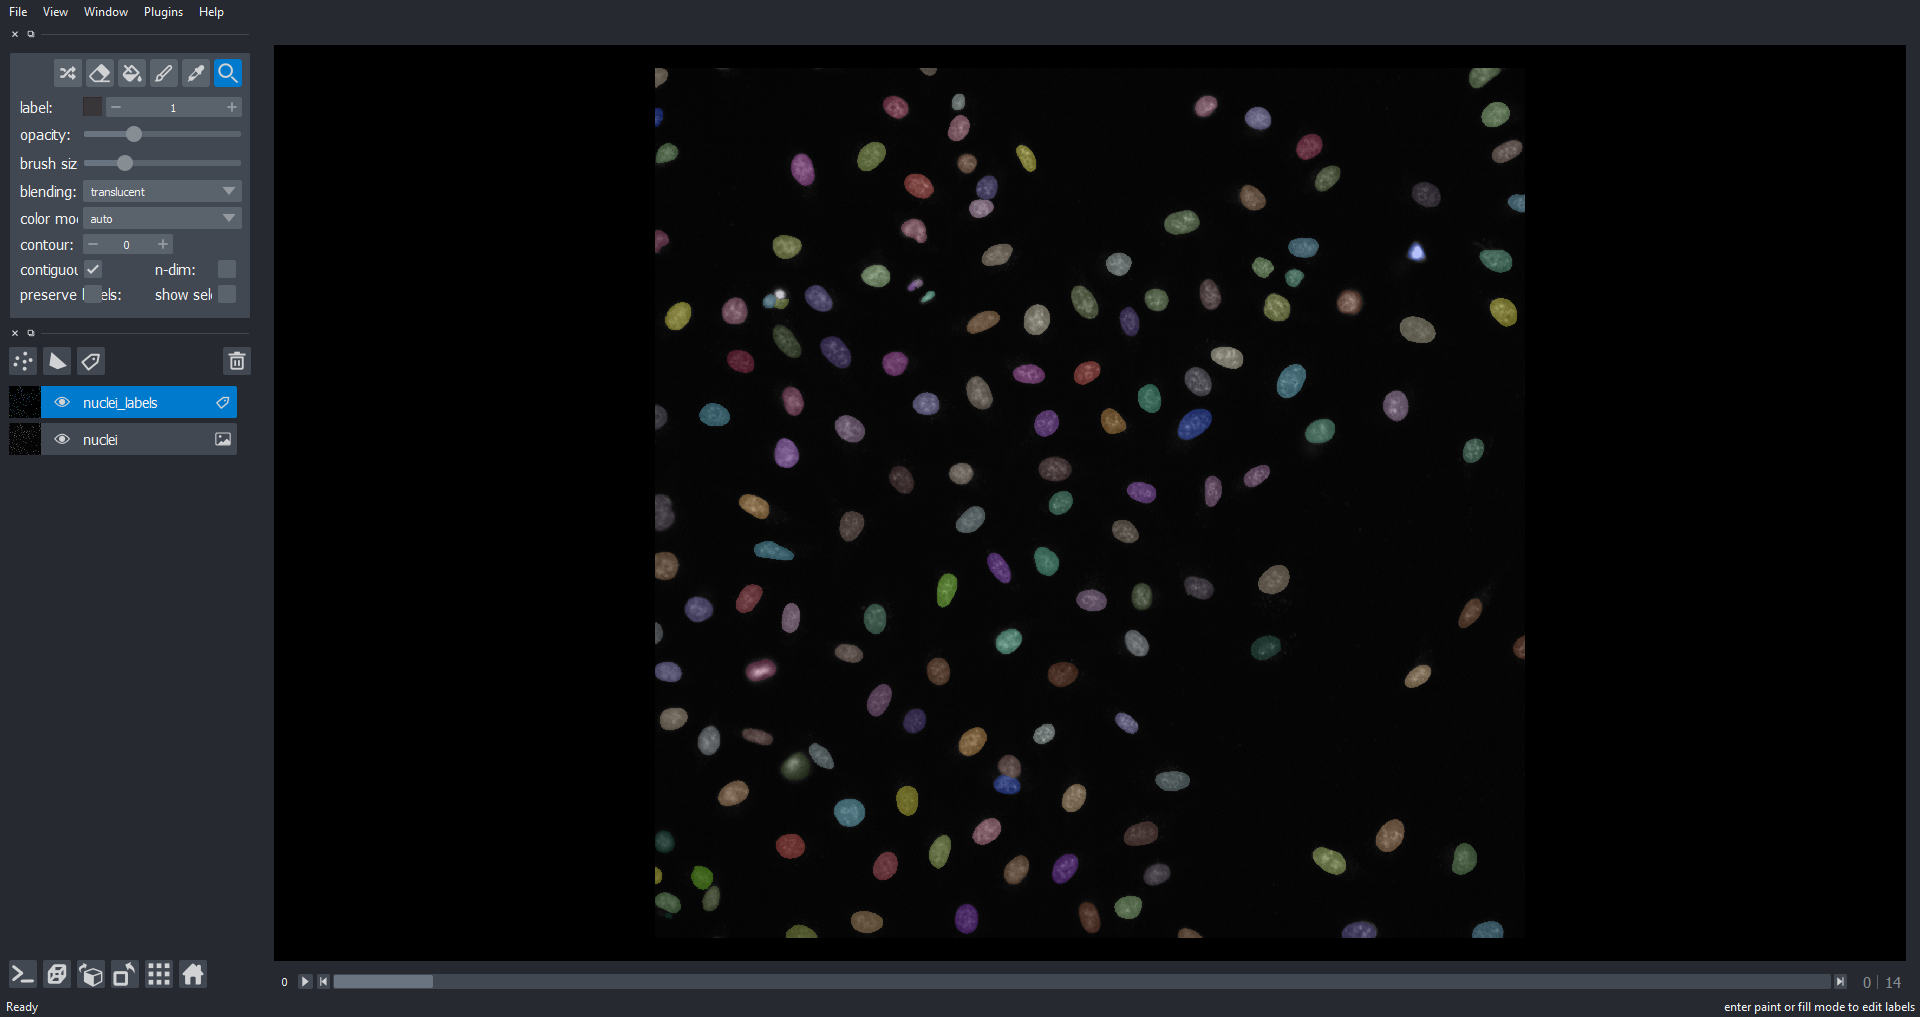

In [6]:
v = napari.Viewer() # create viewer
v.add_image(nuclei, contrast_limits=(nuclei.min(), nuclei.max()*0.5)) # add original nuclei image
v.add_labels(nuclei_labels, opacity=0.3) # add predicted nuclei labels
nbscreenshot(v)

### Remarks
This nuclei image is actually pretty easy to segment even without StarDist. This could be easily done with a pipeline similar to [this one](https://scikit-image.org/docs/dev/user_guide/tutorial_segmentation.html).

For this reason I included in the data folder a _more difficult_ image that would be nearly impossible to segment with classical approaches and yet works fantastically well with StarDist. In this notebook I don't cover the segmentation of the _difficult_ images, but that's actually the dataset I images during my PhD, and with some manual corrections it worked pretty well.

## Tracking
Now that we have segmented each frame independently  we need a way to keep track of each nucleus in time (frame by frame), so this is a tracking problem. I landed on the use of bayesian tracker (btrack), because of its integration with napari, and it worked quite well as you can see below. 
P.S. It also work excellently with my _difficult_ images in which nuclei and cells move much more than these ones.

In [7]:
objects = btrack.utils.segmentation_to_objects(nuclei_labels)
    # Tracks defined objects across time
with btrack.BayesianTracker() as tracker:
    # configure the tracker using a config file
    tracker.configure_from_file('../assets/cell_config.json')

    # append the objects to be tracked
    tracker.append(objects) 
    
    # set the volume (Z axis volume is set very large for 2D data)
    tracker.volume=((0, 2000), (0, 2000), (-1e5, 1e5))

    # track them (in interactive mode)
    tracker.track_interactive(step_size=100)

    # generate hypotheses and run the global optimizer
    tracker.optimize()

    # get the data in a format for napari
    data, properties, graph = tracker.to_napari(ndim=2)

[INFO][2022/03/20 10:37:29 AM] Localizing objects from segmentation...
[INFO][2022/03/20 10:37:29 AM] Objects are of type: <class 'dict'>
[INFO][2022/03/20 10:37:29 AM] ...Found 2399 objects in 15 frames.
[INFO][2022/03/20 10:37:29 AM] Loaded btrack: c:\users\marco dalla vecchia\appdata\local\programs\python\python37\lib\site-packages\btrack\libs\libtracker.DLL
[INFO][2022/03/20 10:37:29 AM] btrack (v0.4.2) library imported
[INFO][2022/03/20 10:37:29 AM] Setting max XYZ search radius to: 100
[INFO][2022/03/20 10:37:29 AM] Starting BayesianTracker session
[INFO][2022/03/20 10:37:29 AM] Loading configuration file: ../assets/cell_config.json
[INFO][2022/03/20 10:37:29 AM] Loading motion model: b'cell_motion'
[INFO][2022/03/20 10:37:29 AM] Objects are of type: <class 'list'>
[INFO][2022/03/20 10:37:29 AM] Set volume to ((0, 2000), (0, 2000), (-100000.0, 100000.0))
[INFO][2022/03/20 10:37:29 AM] Starting tracking... 
[INFO][2022/03/20 10:37:29 AM] Tracking objects in frames 0 to 15 (of 15).

divide by zero encountered in true_divide


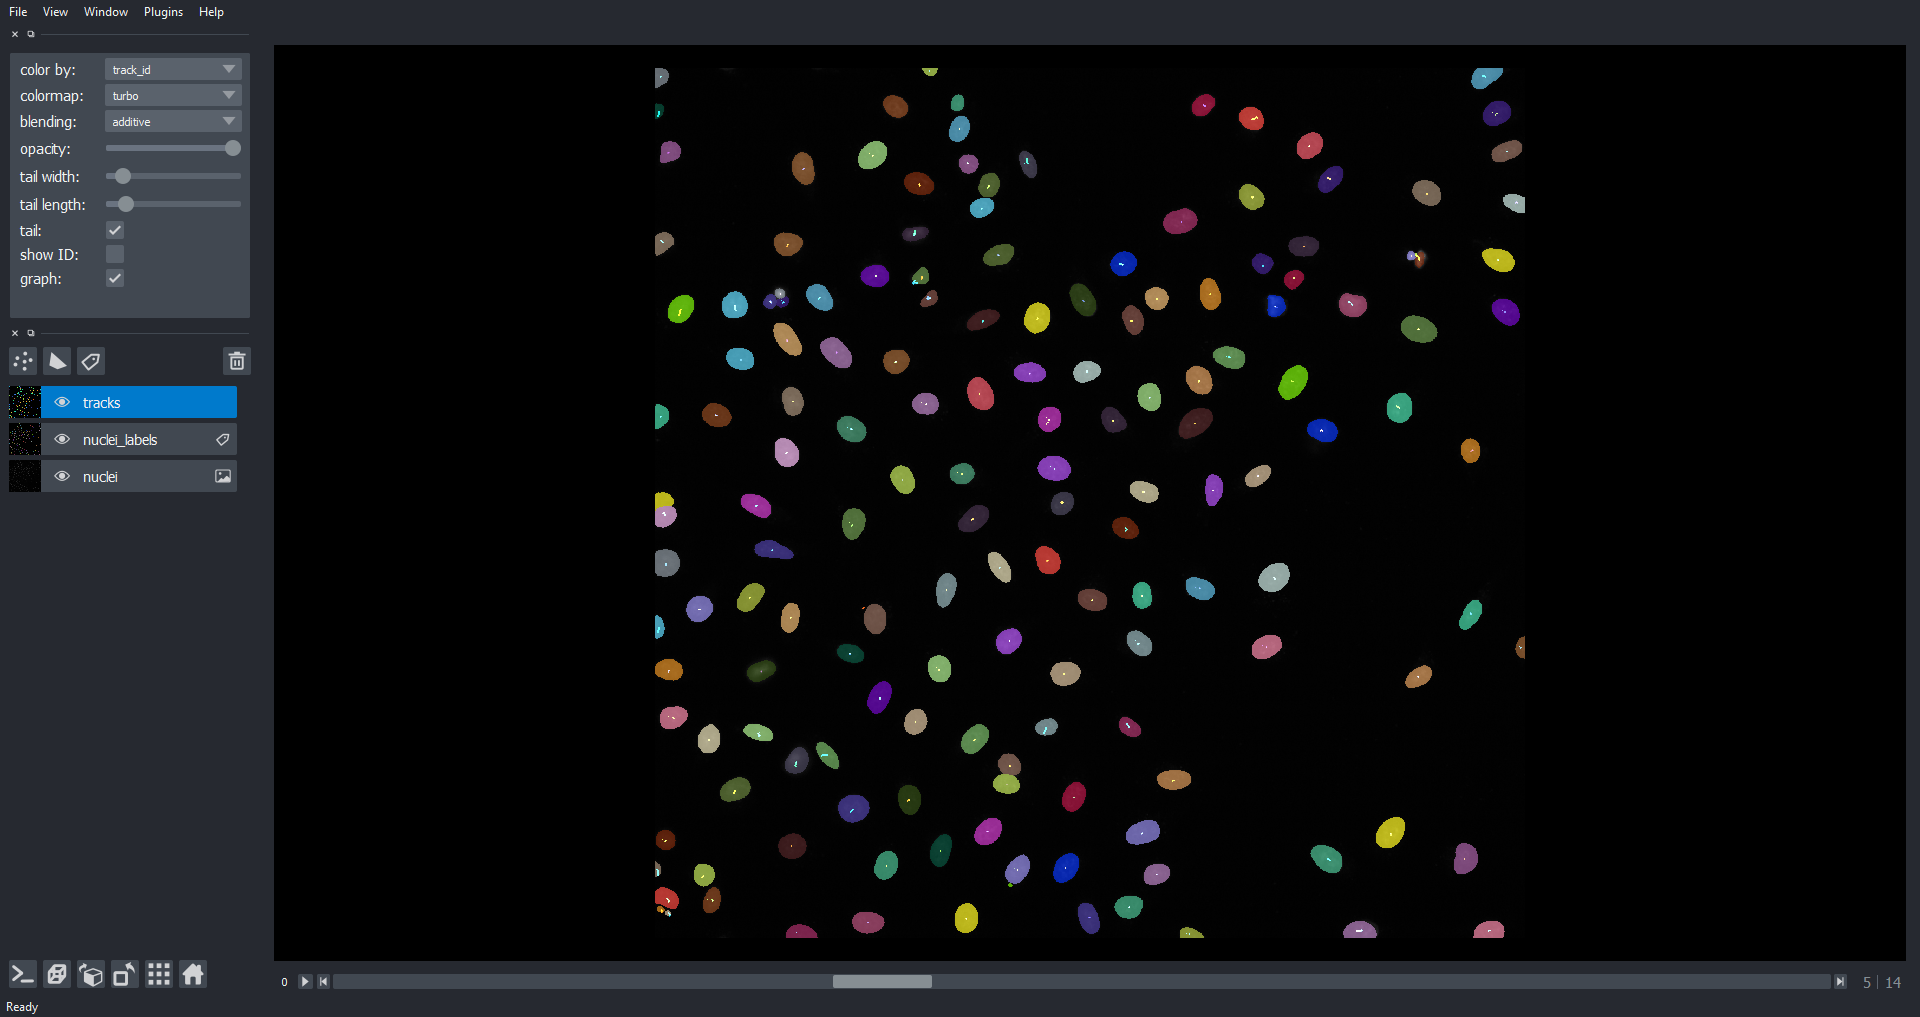

In [8]:
v = napari.Viewer() # create viewer
v.add_image(nuclei) # add original image to segment
v.add_labels(nuclei_labels) # add predicted nuclear labels
v.add_tracks(data, properties=properties, graph=graph, name='tracks') #  add tracks from bayesian tracker
v.dims.current_step = (5,0,0) # change slider step to actually see the tracks tails (at frame 0 they are not visible because there is nothing to track)
nbscreenshot(v)

### Convert tracks to actual labeled images
As you can see from the viewer, while the **tracks** are good, the **labels** of the nuclei are still all over the place. For the future step to work properly we need to keep a homogenous label numbering for each nucleus. This means that nucleus 113 (for example) has to always be 113 for the whole image stack (in time), otherwise we will confuse for another nucleus down the road.

To do this I wrote a function in the utils.py that does all the work. If you are interested check out that file in the modules folder.

In [9]:
# Use tracks from btrack to create masks with same label
tracked_labels = np.array(TracksToLabels(data, nuclei_labels))
# Visualize tracked_labels
v = napari.Viewer()
v.add_image(nuclei) # add original nuclei image for context
v.add_labels(tracked_labels) # add labels that we just modified
v.add_tracks(data, properties=properties, graph=graph, name='tracks') #  add tracks from bayesian tracker

divide by zero encountered in true_divide


<Tracks layer 'tracks' at 0x1db0665f388>

### Remarks
We now have all nuclei labels appearing the same color, meaning that they have the same label value that we can now use to calculate information with for each nucleus.

### Removing _bad_ nuclei
I filtered out all nuclei that are touching the borders and all nuclei that were not properly tracked, i.e. that are not present in all time frames.

One could come up with further filtering criteria in terms of displacement distance from the starting frame for example or based on the shape or size of the nucleus. But I decided to simply keep the filtering to a simple criteria and proceed with cell segmentation from here.

In [10]:
# Remove nuclei touching the image border
cleared_labels = tracked_labels.copy() # create an array copy to fill with cleared images
for layID, layer in enumerate(tracked_labels):
    cleared_labels[layID] = clear_border(layer)

# Create an array Layers X Labels that has True if label is present or False if not
layers_x_labels = []
for layer in tqdm(cleared_labels):
    layers_x_labels.append(SelectLabels(layer, cleared_labels.max()))
final = np.array(layers_x_labels)

# check if a given label is True in all time points
# filter all possible available labels by those present in all time points
number_frames = nuclei.shape[0]
common_labels = np.arange(0, cleared_labels.max()+1)[final.sum(axis=0) == number_frames]
# create final mask with those common labels
final_labels = np.isin(cleared_labels, common_labels) * cleared_labels

v =  napari.Viewer()
v.add_image(nuclei)
v.add_labels(final_labels)

  0%|          | 0/15 [00:00<?, ?it/s]

divide by zero encountered in true_divide


<Labels layer 'final_labels' at 0x1db1c55fd48>

In [11]:
# export tracked and cleared segmented nuclei

# I could have remapped the label values but I preferred to keep the original values from btrack
print(final_labels.max())
if final_labels.max() > 255: # check if label values are higher than 2^8
    final_labels = np.uint16(final_labels)
else: final_labels = np.uint8(final_labels) # if they are not then we can save them as 8bit images
tf.imwrite(output_path + "xy1_tracked_nuclei.tif", final_labels)

157


In [15]:
# Export for presentation

from skimage.exposure import rescale_intensity
from skimage.segmentation import mark_boundaries
from skimage import io

boundaries = rescale_intensity(nuclei[0], in_range=(nuclei[0].min(),nuclei[0].max()*0.5))
tt = np.uint8(mark_boundaries(boundaries, final_labels[0])*255)
io.imsave(output_path+'nuclei_boundaries.png', tt)